# Compare to the Lane et al 

In [2]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [4]:
data_dir = Path('data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [6]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

In [7]:
# read in the training data
ds = xr.open_dataset(Path(f'data/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}'))

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(Path(f'data/interim/static/data.nc'))
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [8]:
# 13 test stations
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

# Open FUSE Models

In [9]:
all_paths = [d for d in (data_dir / "gcloud/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "gcloud/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "gcloud/fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "gcloud/ALL_fuse_ds.nc")

100%|██████████| 1013/1013 [01:05<00:00, 15.54it/s]


# NOTE: only test performance on 2004-2008

In [10]:
fuse_ds = fuse_ds.sel(time=slice('2004-01-01', '2009-01-01'))
fuse_ds

<xarray.Dataset>
Dimensions:          (station_id: 1013, time: 1827)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 4.96 3.82 ... 0.7572 0.6296
    SimQ_ARNOVIC     (station_id, time) float64 5.852 5.036 ... 1.302 1.167
    SimQ_PRMS        (station_id, time) float64 6.469 5.188 ... 0.7446 0.5566
    SimQ_SACRAMENTO  (station_id, time) float64 5.997 4.708 3.97 ... 1.217 1.046

In [11]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["target_var_original"]
).rename("discharge_spec")

In [12]:
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

# Hydrographs

In [13]:
df = fuse_data.sel(time=(fuse_data['time.year'] == 2008).values).isel(station_id=10).to_dataframe().drop('station_id', axis=1)
df = df[["discharge_spec"] + [c for c in df.columns if "spec" not in c]]

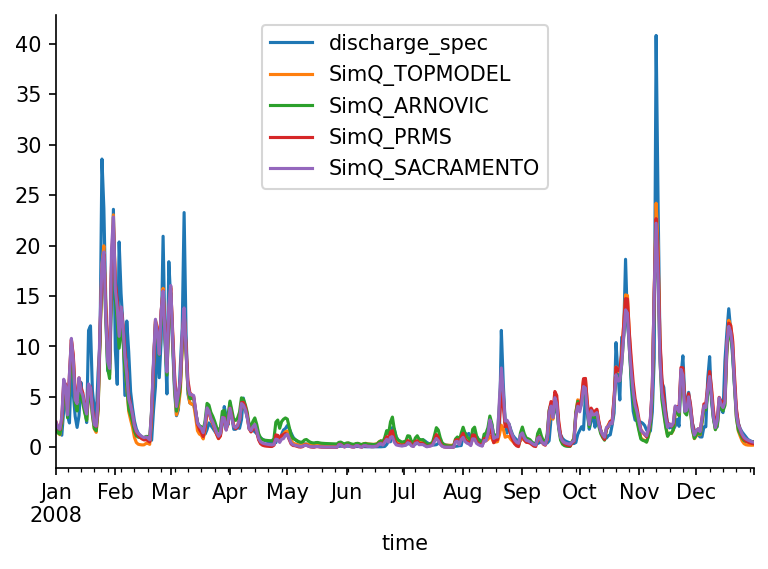

In [14]:
df.plot()
sns.despine()

In [41]:
fuse_data = fuse_data.rename({'discharge_spec': 'obs'})
fuse_data.to_netcdf(data_dir / 'gcloud/fuse_data.nc')

# 13 Catchments

In [16]:
from typing import (Tuple, Dict, Optional, List, Union, Any)

def remove_invalid_vals(x, y) -> Tuple[np.ndarray, np.ndarray]:
    """check for infinite or nan values
    
    Required for np.polyfit:
    https://stackoverflow.com/a/13693657/9940782
    """
    isfinite = np.isfinite(y) & np.isfinite(x)
    notnull = pd.notnull(y) & pd.notnull(x)
    
    x = x[isfinite & notnull]
    y = y[isfinite & notnull]
    
    return x, y
    

def plot_1_1_line(x: np.ndarray, ax) -> plt.Axes:
    # plot 1:1 line
    line_1_1_x = np.linspace(x.min(), x.max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line', alpha=0.5)
    return ax


def plot_scatter(x: np.ndarray, y: np.ndarray, ax, one_to_one: bool = True, **kwargs) -> plt.Axes:
    """Scatter plot of x vs. y"""
    # plot scatter
    ax.plot(x, y, 'kx', **kwargs)
    
    if one_to_one:
        # plot 1:1 line
        ax = plot_1_1_line(x, ax)

    return ax


def plot_reg_line(x: np.ndarray, y: np.ndarray, ax, auto_label: bool = True, **kwargs):
    """plot linear regression line of x vs. y"""
    # plot regression line
    x, y = remove_invalid_vals(x, y)
    m, b = np.polyfit(x, y, 1)
    reg = (m * x + b)
    if auto_label:
        label = f'Regression Line: {m:.2f}X + {b:.2f}'
        ax.plot(x, reg, label=label, **kwargs)
    else:
        ax.plot(x, reg, **kwargs)

    return ax


def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station & data
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    x = d[target_var]
    y = d.preds
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    kwargs = dict(alpha=0.6, label='Data Point')
    ax = plot_scatter(x, y, ax, **kwargs)

    # plot regression line
    kwargs = dict(color = '#7bd250', ls='--')
    ax = plot_reg_line(x, y, ax=ax, **kwargs)

    # make the plot pretty
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    if 'month' in df.columns:
        df = df.drop(columns='month')
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

In [17]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [18]:
fuse_13 = fuse_data.sel(station_id=np.isin(fuse_data['station_id'], catchment_ids))

In [19]:
fuse_13

<xarray.Dataset>
Dimensions:          (station_id: 13, time: 1827)
Coordinates:
  * station_id       (station_id) int64 12002 15006 27009 ... 54057 71001 84013
  * time             (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 4.517 3.543 ... 0.5757 0.5692
    SimQ_ARNOVIC     (station_id, time) float64 4.767 3.417 ... 1.212 1.193
    SimQ_PRMS        (station_id, time) float64 4.915 4.027 ... 0.7254 0.6173
    SimQ_SACRAMENTO  (station_id, time) float64 4.026 3.018 ... 0.9727 0.8898
    discharge_spec   (time, station_id) float64 ...

# Errors

In [20]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse, spatial_bias
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

In [21]:
obs = fuse_data["discharge_spec"].transpose("station_id", "time")
topmodel = fuse_data["SimQ_TOPMODEL"]
arnovic = fuse_data["SimQ_ARNOVIC"]
prms = fuse_data["SimQ_PRMS"]
sacramento = fuse_data["SimQ_SACRAMENTO"]

In [22]:
static['gauge_name'].to_dataframe()

,gauge_name
station_id,
1001,Wick at Tarroul
2001,Helmsdale at Kilphedir
2002,Brora at Bruachrobie
3003,Oykel at Easter Turnaig
4001,Conon at Moy Bridge
...,...
101002,Medina at Shide
101005,Eastern Yar at Budbridge
102001,Cefni at Bodffordd


## NSE

In [23]:
top_nse = spatial_nse(obs, topmodel).rename("TOPMODEL")
vic_nse = spatial_nse(obs, arnovic).rename("VIC")
prms_nse = spatial_nse(obs, prms).rename("PRMS")
sac_nse = spatial_nse(obs, sacramento).rename("Sacramento")

In [24]:
nse = xr.merge([
    top_nse,
    vic_nse,
    prms_nse,
    sac_nse,
])
nse_df = nse.to_dataframe()
nse_df = static['gauge_name'].to_dataframe().join(nse_df).rename(columns=dict(gauge_name="Name"))
nse_df.to_csv(data_dir / 'gcloud/FUSE_nse_table.csv')
nse_df.columns = [["nse" for _ in range(len(nse_df.columns))], nse_df.columns]


In [25]:
top_rmse = spatial_rmse(obs, topmodel).rename("TOPMODEL")
vic_rmse = spatial_rmse(obs, arnovic).rename("VIC")
prms_rmse = spatial_rmse(obs, prms).rename("PRMS")
sac_rmse = spatial_rmse(obs, sacramento).rename("Sacramento")

rmse = xr.merge([
    top_rmse,
    vic_rmse,
    prms_rmse,
    sac_rmse,
])
rmse_df = rmse.to_dataframe().drop(columns='time')
rmse_df.to_csv(data_dir / 'gcloud/FUSE_rmse_table.csv')
rmse_df.columns = [["rmse" for _ in range(len(rmse_df.columns))], rmse_df.columns]


In [26]:
top_r2 = spatial_r2(obs, topmodel).rename("TOPMODEL")
vic_r2 = spatial_r2(obs, arnovic).rename("VIC")
prms_r2 = spatial_r2(obs, prms).rename("PRMS")
sac_r2 = spatial_r2(obs, sacramento).rename("Sacramento")

r2 = xr.merge([
    top_r2,
    vic_r2,
    prms_r2,
    sac_r2,
])
r2_df = r2.to_dataframe().drop(columns='time')
r2_df.to_csv(data_dir / 'gcloud/FUSE_r2_table.csv')
r2_df.columns = [["r2" for _ in range(len(r2_df.columns))], r2_df.columns]

In [27]:
top_bias = spatial_bias(obs, topmodel).rename("TOPMODEL")
vic_bias = spatial_bias(obs, arnovic).rename("VIC")
prms_bias = spatial_bias(obs, prms).rename("PRMS")
sac_bias = spatial_bias(obs, sacramento).rename("Sacramento")

bias = xr.merge([
    top_bias,
    vic_bias,
    prms_bias,
    sac_bias,
])
bias_df = bias.to_dataframe()
bias_df.to_csv(data_dir / 'gcloud/FUSE_bias_table.csv')
bias_df.columns = [["bias" for _ in range(len(bias_df.columns))], bias_df.columns]

In [28]:
fuse_errors = pd.concat([nse_df, rmse_df, r2_df, bias_df], axis=1)
fuse_errors = fuse_errors.drop('time', axis=1, level=1).swaplevel(axis=1).sort_index(axis=1)
fuse_errors.to_csv(data_dir / 'gcloud/FUSE_errors.csv')
fuse_errors.to_pickle(data_dir / 'gcloud/FUSE_errors.pkl')

### 13 stations

In [29]:
fuse_13 = fuse_errors.loc[np.isin(fuse_errors.index, catchment_ids)]
fuse_13 = fuse_13.rename(columns=dict(nse="NSE", r2="R2", rmse="RMSE", catchment_name="Name"))
fuse_13.index.name = "Station ID"
fuse_13

Name       PRMS                                \
                                NSE       bias       NSE        R2      RMSE   
Station ID                                                                     
12002                   Dee at Park  -3.035800  0.645595  0.645913  1.140287   
15006              Tay at Ballathie  -7.013328  0.863550  0.891737  1.112856   
27009               Ouse at Skelton   3.035358  0.878628  0.893960  0.556716   
27034         Ure at Kilgram Bridge  -0.921798  0.846080  0.853459  1.751756   
27041       Derwent at Buttercrambe  10.312414  0.781723  0.930574  0.328869   
39001            Thames at Kingston  46.282385  0.634762  0.963084  0.319414   
39081               Ock at Abingdon  -5.997321  0.708910  0.951670  0.351145   
43021            Avon at Knapp Mill  15.555114  0.791659  0.962223  0.258339   
47001           Tamar at Gunnislake  -2.664355  0.853336  0.853354  0.949856   
54001             Severn at Bewdley  13.466011  0.848889  0.903182  0.468342   
54057          Severn at Haw Bridge   3.802692  0.870411  0.938555  0.370663   
71001          Ribble at Samlesbury   0.327128  0.831588  0.837263  1.508619   
84013             Clyde at Daldowie   7.981717  0.870042  0.870554  0.898589   

           Sacramento                                 TOPMODEL            \
                 bias       NSE        R2      RMSE       bias       NSE   
Station ID                                                                 
12002       -7.205577  0.648255  0.649765  1.136000  -5.942977  0.556630   
15006       -8.619510  0.879369  0.906053  1.046360  -8.805878  0.803730   
27009        3.375319  0.900831  0.910980  0.503225   3.980303  0.861834   
27034       -9.449231  0.850750  0.858860  1.724981  -6.602561  0.838496   
27041       10.898775  0.809577  0.933627  0.307170   1.412459  0.745959   
39001       21.184702  0.818929  0.980187  0.224901  16.526875  0.731836   
39081      -16.376295  0.823289  0.968235  0.273593 -11.849456  0.710893   
43021        6.302035  0.797063  0.959544  0.254967  33.324338  0.278183   
47001       -4.217859  0.858073  0.858284  0.934389  -5.974199  0.851288   
54001       11.820826  0.903441  0.934713  0.374378  18.927446  0.854216   
54057        2.524775  0.911889  0.955354  0.305640   7.810071  0.888451   
71001       -1.967546  0.843933  0.850247  1.452274   0.833191  0.832278   
84013        2.600944  0.905927  0.906688  0.764525   1.668957  0.898075   

                                      VIC                                
                  R2      RMSE       bias       NSE        R2      RMSE  
Station ID                                                               
12002       0.559781  1.275403   7.123732  0.633095  0.633105  1.160222  
15006       0.848675  1.334686   7.224393  0.892683  0.913308  0.986927  
27009       0.874311  0.593983   8.811956  0.889123  0.905913  0.532102  
27034       0.847841  1.794398  -3.456757  0.845481  0.851961  1.755163  
27041       0.906971  0.354790  20.457355  0.713918  0.916719  0.376500  
39001       0.969360  0.273695  17.653984  0.734690  0.975146  0.272234  
39081       0.945739  0.349947 -10.369773  0.812519  0.971159  0.281807  
43021       0.848469  0.480858  13.060202  0.841176  0.973696  0.225560  
47001       0.851707  0.956466  14.790210  0.861083  0.861121  0.924427  
54001       0.898636  0.460012   7.134334  0.861241  0.915809  0.448792  
54057       0.941453  0.343897   8.877016  0.862782  0.939066  0.381417  
71001       0.839703  1.505523   4.358927  0.832930  0.837533  1.502596  
84013       0.899183  0.795793  15.913328  0.891100  0.891238  0.822574

In [30]:
print(fuse_13.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrrrrrrrrrr}
\toprule
{} &                     Name & \multicolumn{4}{l}{PRMS} & \multicolumn{4}{l}{Sacramento} & \multicolumn{4}{l}{TOPMODEL} & \multicolumn{4}{l}{VIC} \\
{} &                      NSE &  bias &  NSE &   R2 & RMSE &       bias &  NSE &   R2 & RMSE &     bias &  NSE &   R2 & RMSE &   bias &  NSE &   R2 & RMSE \\
Station ID &                          &       &      &      &      &            &      &      &      &          &      &      &      &        &      &      &      \\
\midrule
12002      &              Dee at Park & -3.04 & 0.65 & 0.65 & 1.14 &      -7.21 & 0.65 & 0.65 & 1.14 &    -5.94 & 0.56 & 0.56 & 1.28 &   7.12 & 0.63 & 0.63 & 1.16 \\
15006      &         Tay at Ballathie & -7.01 & 0.86 & 0.89 & 1.11 &      -8.62 & 0.88 & 0.91 & 1.05 &    -8.81 & 0.80 & 0.85 & 1.33 &   7.22 & 0.89 & 0.91 & 0.99 \\
27009      &          Ouse at Skelton &  3.04 & 0.88 & 0.89 & 0.56 &       3.38 & 0.90 & 0.91 & 0.50 &     3.98 & 0.86 & 0.87 & 0.59 &   8.8

In [31]:
nse_df.columns

MultiIndex([('nse',       'Name'),
            ('nse',   'TOPMODEL'),
            ('nse',        'VIC'),
            ('nse',       'PRMS'),
            ('nse', 'Sacramento')],
           )

# distribution of errors

In [32]:
nse_df.columns = ["Name", "TOPMODEL", "VIC", "PRMS", "Sacramento"]
nse_df.to_csv(data_dir / "gcloud/FUSE_nse_all_stations.csv")

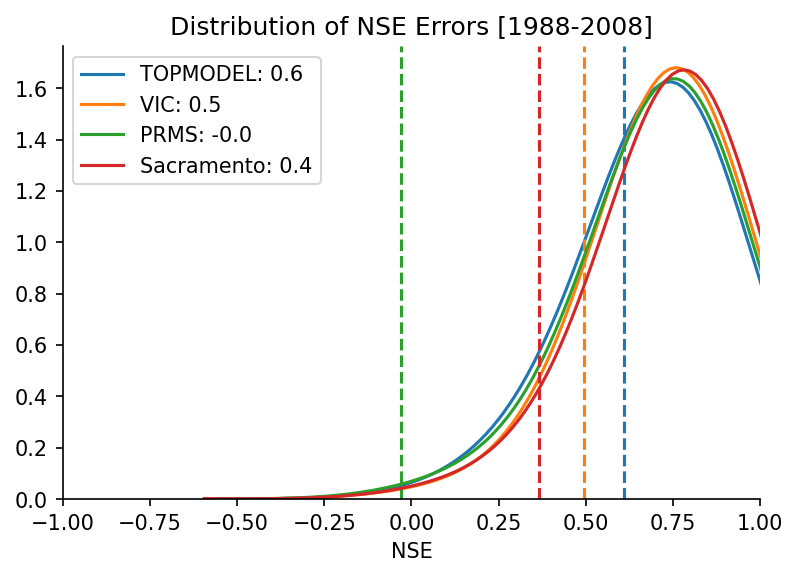

In [33]:
fig, ax = plt.subplots()
colors = sns.color_palette()

for ix, model in enumerate([c for c in nse_df.columns if c != "Name"]):
    sns.kdeplot(nse_df[model], ax=ax, label=f"{model}: {nse_df[model].mean():.1f}", bw=0.2, clip=(0, 1), color=colors[ix])
    ax.axvline(nse_df[model].mean(), ls='--', color=colors[ix])

ax.set_xlim([-1, 1])
ax.set_xlabel('NSE')

ax.set_title("Distribution of NSE Errors [1988-2008]")
sns.despine()

# Open the Less Vars experiments (2004-2015 test)

In [34]:
print([d.name for d in (data_dir/'gcloud').iterdir()])
print([d.name for d in (data_dir/'gcloud/less_vars_2004_2015/').iterdir()])

['Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC', 'conceptual_models.pkl', 'less_vars_2004_2015', 'results_lstm_less_vars_1307_1717_E015.csv', 'FUSE_bias_table.csv', 'wget-log', 'FUSE_errors.pkl', 'process_models.pkl', 'ealstm_less_vars', 'lstm20', '.ipynb_checkpoints', 'lstm_0807_2105', 'jules_classic.csv', 'plots', 'fuse_ds.nc', 'lstm_less_vars', 'all_lstm_0807_2105_results.csv', 'natural_earth_hires', '3ma509dlakcf720aw8x82aq4tm.zip.1', 'FUSE_nse_all_stations.csv', 'vars', 'FUSE_r2_table.csv', 'lstm_less_vars_2004_2005_final.csv', 'ealstm20', 'FUSE_rmse_table.csv', 'FUSE', 'FUSE_nse_table.csv', 'FUSE_errors.csv']
['results_ealstm_less_vars_2004_1707_1424_E011.csv', 'all_lstm_less_vars_2004_1507_1028_results.csv', '.ipynb_checkpoints', 'old']


In [35]:
all_lstm = pd.read_csv(data_dir/"gcloud/less_vars_2004_2015/all_lstm_less_vars_2004_1507_1028_results.csv")
all_ealstm = pd.read_csv(data_dir/"gcloud/less_vars_2004_2015/results_ealstm_less_vars_2004_1707_1424_E011.csv")

In [36]:
lstm_df = all_lstm
lstm_df["time"] = pd.to_datetime(lstm_df["time"])
ealstm_df = all_ealstm
ealstm_df["time"] = pd.to_datetime(ealstm_df["time"])


lstm_preds = lstm_df.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_df.set_index(["station_id", "time"]).to_xarray()

In [37]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [38]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
]
ealstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
]
lstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

KeyError: 'sim'

# Get Static data Table

In [ ]:
hydrologic_attributes = [
    "gauge_name",
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "baseflow_index_ceh",
    "hfd_mean",
    "Q5",
    "Q95",
    "high_q_freq",
    "high_q_dur",
    "low_q_freq",
    "low_q_dur",
]

rename = dict(zip(
    hydrologic_attributes,
    [
        "Name",
        "Mean Discharge (Q) ($mm^{-3} day^{-1}$)",
        "Runoff Ratio",
        "Stream elasticity",
        "Slope of the Flow-Duration-Curve",
        "Baseflow Index",
        "Baseflow Index CEH",
        "hfd_mean",
        "Q5 Discharge ($mm^{-3} day^{-1}$)",
        "Q95 Discharge ($mm^{-3} day^{-1}$)",
        "High Discharge (Q) Frequency",
        "High Discharge (Q) Duration",
        "Low Discharge (Q) Frequency",
        "Low Discharge (Q) Duration",
    ]
))

In [ ]:
print(
    static[hydrologic_attributes]
    .sel(station_id=np.isin(static["station_id"], catchment_ids))
    .to_dataframe()
    .rename(columns=rename)
    .to_latex(float_format="%.2f")

)